This notebook performs data synthesis using our proposed synthesization approach applied to simulated churn data. The synthesis model is a multinomial Logistic regression. We use a general purpose optimization function based on the pMSE ratio, where the discriminating model is a logistc regression with two way interactions and polynomials.

In [1]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import itertools
import os
import pickle
import math
import pandas as pd
import numpy as np

from bayes_opt import BayesianOptimization
from bayes_opt import acquisition

from sklearn.preprocessing import StandardScaler

from helper_functions import *

rng = np.random.RandomState(42)

Import the data.

In [2]:
# import simulated churn data
train_data = pd.read_csv("../../Data/Simulations/Churn/churn_simulated.csv")

In [3]:
train_data = train_data.drop('id', axis=1)

In [4]:
train_data

,churn,amount_spent,num_visits,age,hiking_int,sustain_int,online_int
0,1,1087.192472,45,87,0,1,1
1,0,1164.154225,70,39,1,0,1
2,0,1280.900067,84,27,1,1,1
3,1,815.049025,64,65,0,0,1
4,0,1381.933928,67,60,1,1,1
...,...,...,...,...,...,...,...
9995,0,926.103124,21,67,0,1,1
9996,1,1306.133314,72,47,0,1,0
9997,1,648.650000,50,55,0,0,1
9998,0,905.449235,73,25,0,1,1


***

Functions for logistic and multinomial logistic regression synthesizer.

In [5]:
def train_models_mn(#overall parameters
                    train_data,
                    num_vars_synthesized,
                    number_synthetic_datasets,
                    # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                    C_hiking_int,
                    C_sustain_int,
                    C_online_int):
    
    num_samples = train_data.shape[0]

    # normalized version of training data
    scaler = StandardScaler().fit(train_data.loc[:,['amount_spent', 'num_visits', 'age']])
    norm_train = pd.concat([train_data.loc[:, 'churn'], 
                            pd.DataFrame(scaler.transform(train_data.loc[:, ['amount_spent', 'num_visits', 'age']]), columns = ['amount_spent', 'num_visits', 'age']), 
                            train_data.loc[:, ['hiking_int', 'sustain_int', 'online_int']]], axis=1)

    # list for synthetic datasets
    sXs = [norm_train.loc[:, ['churn', 'amount_spent', 'num_visits', 'age']] for i in range(number_synthetic_datasets)]
        
    ####################################################################################################
        
    ########### Code for hiking_int MN ##########
    
    synth_hiking_int_vars = multinomial_synthesizer(orig_data=norm_train.loc[:, ['churn', 'amount_spent', 'num_visits', 'age']], 
                                                    synth_data_sets=sXs, 
                                                    target=norm_train.hiking_int, 
                                                    penalty_param=C_hiking_int)
    sXs = [pd.concat([Y, synth_hiking_int_vars[i]], axis=1) for i,Y in enumerate(sXs)]  

    ####################################################################################################
        
    ########### Code for sustain_int MN ##########
    
    synth_sustain_int_vars = multinomial_synthesizer(orig_data=norm_train.loc[:, ['churn', 'amount_spent', 'num_visits', 'age', 'hiking_int']], 
                                                     synth_data_sets=sXs, 
                                                     target=norm_train.sustain_int, 
                                                     penalty_param=C_sustain_int)
    sXs = [pd.concat([Y, synth_sustain_int_vars[i]], axis=1) for i,Y in enumerate(sXs)]
    
    ####################################################################################################

    ########### Code for online_int MN ##########
    
    synth_online_int_vars = multinomial_synthesizer(orig_data=norm_train.loc[:, ['churn', 'amount_spent', 'num_visits', 'age', 'hiking_int', 'sustain_int']], 
                                                    synth_data_sets=sXs, 
                                                    target=norm_train.online_int, 
                                                    penalty_param=C_online_int)
    sXs = [pd.concat([Y, synth_online_int_vars[i]], axis=1) for i,Y in enumerate(sXs)]
     
    ####################################################################################################
        
    ###### Calculate pMSE ratios ######
    pmse_ratios = [pmse_ratio(norm_train, Y, num_vars_synthesized) for Y in sXs]

    # convert sXs to original scale
    for i, Z in enumerate(sXs):
        H = train_data.sample(frac=1.0, replace=True, ignore_index=True).loc[:, ['amount_spent', 'num_visits', 'age']]
        scaler = StandardScaler().fit(H)
        Z.loc[:, ['amount_spent', 'num_visits', 'age']] = scaler.inverse_transform(Z.loc[:, ['amount_spent', 'num_visits', 'age']])
        Z.loc[:, ['age']] = np.round(Z.loc[:, ['age']], 0)
        Z.loc[:, ['num_visits']] = np.round(Z.loc[:, ['num_visits']], 0)   
    return pmse_ratios, sXs

In [6]:
def optimize_models_mn(train_data,
                       number_synthetic_datasets,
                       random_state):

    def evaluate_models(C_hiking_int, C_sustain_int, C_online_int):

        pmse_ratios, _ = train_models_mn(train_data=train_data,
                                         num_vars_synthesized=3,
                                         number_synthetic_datasets=number_synthetic_datasets,
                                         C_hiking_int=C_hiking_int,
                                         C_sustain_int=C_sustain_int,
                                         C_online_int=C_online_int)
        
        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "C_hiking_int": (0.001, 3),
            "C_sustain_int": (0.001, 3),
            "C_online_int": (0.001, 3)
        },
        verbose=2,
        random_state=random_state,
        acquisition_function=acquisition.ExpectedImprovement(xi=1e-02))
    
    optimizer.maximize(init_points=5, n_iter=25)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value for $\alpha = 1e-06$.

In [7]:
nsd = 10
random_states = [np.random.RandomState(1006), np.random.RandomState(428)]

In [8]:
optimization_results = [optimize_models_mn(train_data=train_data, number_synthetic_datasets=nsd, random_state=r) for r in random_states]

|   iter    |  target   | C_hiki... | C_onli... | C_sust... |
-------------------------------------------------------------


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 1         | -704.2    | 2.23      | 0.68      | 1.928     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -783.5    | 2.647     | 2.222     | 2.164     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 3         | -599.6    | 0.8867    | 1.577     | 0.5221    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 4         | -667.1    | 2.436     | 2.548     | 0.7703    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 5         | -662.5    | 0.7125    | 1.376     | 0.6875    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 6         | -591.5    | 0.9787    | 1.683     | 0.4355    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 7         | -606.6    | 0.7551    | 1.705     | 0.1608    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 8         | -621.0    | 1.2       | 1.405     | 0.2087    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 9         | -617.2    | 0.8173    | 2.096     | 0.6024    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 10        | -632.7    | 1.33      | 1.742     | 0.7307    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 11        | -3.186e+0 | 0.04202   | 2.898     | 0.001     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 12        | -751.0    | 1.204     | 2.168     | 1.856     |
| 13        | -2.965e+0 | 0.4905    | 0.01703   | 0.003606  |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 14        | -661.9    | 3.0       | 1.253     | 0.9009    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 15        | -784.1    | 3.0       | 0.9339    | 3.0       |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 16        | -756.7    | 1.246     | 0.8497    | 3.0       |
| 17        | -4.187e+0 | 2.898     | 0.001     | 0.001     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 18        | -739.4    | 3.0       | 1.668     | 1.407     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 19        | -783.6    | 2.141     | 1.612     | 2.976     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 20        | -1.631e+0 | 0.001     | 0.04758   | 2.158     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 21        | -768.6    | 2.156     | 0.3283    | 3.0       |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 22        | -689.9    | 2.012     | 1.505     | 1.871     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 23        | -755.1    | 3.0       | 3.0       | 3.0       |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 24        | -771.6    | 1.595     | 3.0       | 3.0       |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 25        | -721.8    | 2.044     | 3.0       | 1.898     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -3.065e+0 | 0.3606    | 0.9323    | 0.001     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 27        | -712.5    | 0.7985    | 1.575     | 1.279     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 28        | -696.4    | 2.319     | 1.714     | 0.9332    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -733.5    | 1.843     | 2.339     | 2.52      |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 30        | -638.6    | 1.88      | 2.002     | 0.05706   |
Final Result:  {'target': -591.5242102375619, 'params': {'C_hiking_int': 0.9786746294109099, 'C_online_int': 1.6829165708522664, 'C_sustain_int': 0.43553543789499527}}
|   iter    |  target   | C_hiki... | C_onli... | C_sust... |
-------------------------------------------------------------


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 1         | -717.4    | 2.455     | 2.623     | 1.256     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -530.8    | 1.336     | 0.3865    | 0.3158    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 3         | -689.2    | 1.939     | 2.886     | 0.873     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 4         | -799.9    | 0.2011    | 1.478     | 1.208     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 5         | -603.2    | 0.6546    | 2.504     | 0.5472    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 6         | -537.6    | 1.479     | 0.258     | 0.1982    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 7         | -2.919e+0 | 1.464     | 0.7709    | 0.001     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 8         | -563.7    | 1.356     | 0.169     | 0.3833    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 9         | -719.9    | 2.126     | 2.665     | 1.097     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 10        | -759.3    | 1.618     | 2.866     | 2.026     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 11        | -651.4    | 2.347     | 2.994     | 1.023     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 12        | -712.9    | 2.068     | 2.972     | 1.415     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 13        | -618.1    | 0.4591    | 1.144     | 0.3143    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 14        | -731.4    | 2.438     | 0.7982    | 1.975     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 15        | -692.9    | 1.167     | 0.2429    | 1.549     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 16        | -843.7    | 0.1347    | 2.888     | 2.529     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 17        | -703.5    | 0.3223    | 1.311     | 0.7287    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 18        | -732.4    | 1.89      | 2.623     | 1.675     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 19        | -781.6    | 2.104     | 1.412     | 1.419     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 20        | -742.4    | 0.5275    | 0.3956    | 1.072     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 21        | -789.8    | 2.504     | 2.836     | 2.191     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 22        | -688.9    | 1.815     | 0.9055    | 1.11      |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 23        | -765.5    | 2.255     | 2.897     | 1.814     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 24        | -761.9    | 2.111     | 0.9259    | 1.531     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 25        | -649.6    | 1.031     | 0.3895    | 0.6503    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -637.4    | 0.6504    | 2.483     | 0.6022    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 27        | -650.3    | 1.022     | 0.4059    | 0.6592    |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 28        | -612.7    | 2.621     | 0.9138    | 0.09075   |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -762.6    | 1.263     | 0.6617    | 1.207     |


C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 30        | -704.8    | 0.2788    | 0.7503    | 0.6553    |
Final Result:  {'target': -530.8239551295289, 'params': {'C_hiking_int': 1.3362145452508853, 'C_online_int': 0.3865150784750532, 'C_sustain_int': 0.315751177927139}}


In [9]:
optimization_results

[({'target': -591.5242102375619,
   'params': {'C_hiking_int': 0.9786746294109099,
    'C_online_int': 1.6829165708522664,
    'C_sustain_int': 0.43553543789499527}},
  <bayes_opt.bayesian_optimization.BayesianOptimization at 0x21bf4b18d70>),
 ({'target': -530.8239551295289,
   'params': {'C_hiking_int': 1.3362145452508853,
    'C_online_int': 0.3865150784750532,
    'C_sustain_int': 0.315751177927139}},
  <bayes_opt.bayesian_optimization.BayesianOptimization at 0x21bf4011670>)]

In [10]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

In [11]:
print(run_targets)

[array([704.18544976, 704.18544976, 599.64381597, 599.64381597,
       599.64381597, 591.52421024, 591.52421024, 591.52421024,
       591.52421024, 591.52421024, 591.52421024, 591.52421024,
       591.52421024, 591.52421024, 591.52421024, 591.52421024,
       591.52421024, 591.52421024, 591.52421024, 591.52421024,
       591.52421024, 591.52421024, 591.52421024, 591.52421024,
       591.52421024, 591.52421024, 591.52421024, 591.52421024,
       591.52421024, 591.52421024]), array([717.44491262, 530.82395513, 530.82395513, 530.82395513,
       530.82395513, 530.82395513, 530.82395513, 530.82395513,
       530.82395513, 530.82395513, 530.82395513, 530.82395513,
       530.82395513, 530.82395513, 530.82395513, 530.82395513,
       530.82395513, 530.82395513, 530.82395513, 530.82395513,
       530.82395513, 530.82395513, 530.82395513, 530.82395513,
       530.82395513, 530.82395513, 530.82395513, 530.82395513,
       530.82395513, 530.82395513])]


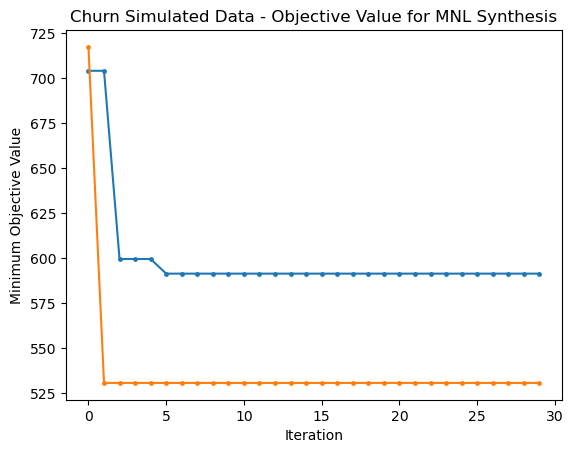

In [12]:
fig = plt.figure()
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("Churn Simulated Data - Objective Value for MNL Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
# fig.savefig('../Images/min_objective_mnl_ipums.pdf')
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [13]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [14]:
best_params

{'target': -530.8239551295289,
 'params': {'C_hiking_int': 1.3362145452508853,
  'C_online_int': 0.3865150784750532,
  'C_sustain_int': 0.315751177927139}}

Generate 20 synthetic data sets.

On occassion, the synthesis models will produce a significantly different fit than what was observed during the optimization process. In these cases, retrain the models until a fit (judged by the pMSE ratio) consistent with the optimization results is observed.

In [15]:
pmse_ratios, full_sXs = train_models_mn(train_data=train_data,
                                        num_vars_synthesized=3,
                                        number_synthetic_datasets=20,
                                        # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                        C_hiking_int=best_params['params']['C_hiking_int'],
                                        C_sustain_int=best_params['params']['C_sustain_int'],
                                        C_online_int=best_params['params']['C_online_int'])

C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\camer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [16]:
np.mean(pmse_ratios)

23.982098084457622

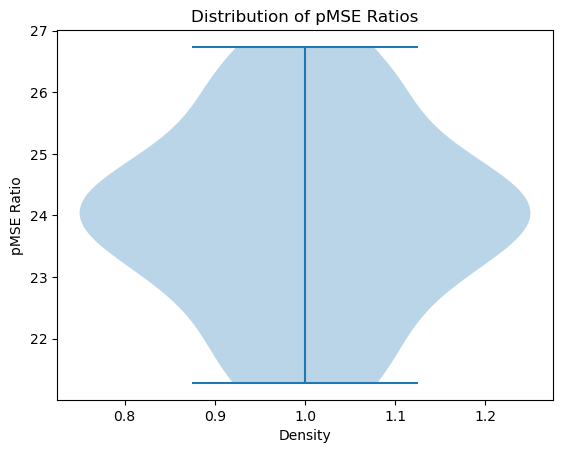

In [17]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

# Save the synthetic datasets.

In [18]:
synthetic_data_path = "../../Data/Simulations/Churn/"

for i, sX in enumerate(full_sXs):
    if not os.path.exists(synthetic_data_path):
        os.makedirs(synthetic_data_path)
    sX.to_csv(synthetic_data_path + "mnl_" + str(i) + ".csv", index=False)

In [10]:
# full_sXs = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv") for i in range(20)]

# # load
# with open('../Results/IPUMS/Models/gmm_and_mnl.pkl', 'rb') as f:
#     GMM = pickle.load(f)

***

Now apply the attribute disclosure prevention algorithm.

We don't have a great baseline for the probability of being non-white, so we'll just use the proportion from the data.

In [11]:
# prior = np.mean(train_data.non_white == 1)

In [12]:
# prior

For our threshold, we select $c = 10$, i.e., we are allowing for a 10x increase in the probability of an adversary inferring the non-white status based on the synthetic data. This is a relatively large increase. For example, this means going from XXX under the prior to no more than XXX under the updated probability.

In [13]:
# c = 3

We provide a range of $\delta$ values over which to evaluate and prevent attribute disclosure.

In [14]:
# deltas = np.linspace(0.001, 0.1, 5)

In [15]:
# ad_sXs = [attribute_disclosure_reduction(original_data=train_data, 
#                                          synthetic_data=X,
#                                          continuous_vars=['incwage', 'years_of_educ', 'potential_experience'],
#                                          categorical_vars=['sex'],
#                                          sensitive_var='non_white',
#                                          num_mixture_components=190,#int(best_params['params']['num_components_']),
#                                          deltas=deltas, 
#                                          c=c, 
#                                          prior_prob=prior) for X in full_sXs]

***

In [16]:
# num_records = train_data.shape[0]

In [17]:
# np.mean([Z.shape[0] - num_records for Z in ad_sXs])

***

In [18]:
# for i, sX in enumerate(ad_sXs):
    
#     # normalize
#     sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']] = StandardScaler().fit_transform(sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
#     full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']] = StandardScaler().fit_transform(full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']])

#     # convert to original scale (un-normalize?)
#     H = train_data.sample(frac=1.0, replace=True, ignore_index=True).loc[:,['incwage', 'years_of_educ', 'potential_experience']]
#     scaler = StandardScaler().fit(H.loc[:, ['incwage', 'years_of_educ', 'potential_experience']])
#     sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']] = scaler.inverse_transform(sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
#     full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']] = scaler.inverse_transform(full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']])
#     sX.to_csv("../Data/IPUMS/Synthetic Datasets/ad_gmm_and_mnl_" + str(i) + ".csv", index=False)
#     full_sXs[i].to_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv", index=False)